# Visualization of data
----
Milan Leonard  
u6661755

----
The purpose of this notebook is to produce the images from the data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pickle as pkl
import pennylane as qml
from pennylane import numpy
import random
from functools import partial
import networkx as nx
from itertools import combinations, groupby
from collections import defaultdict
def strdefaultdict(): # to understand maxcutbenchmark dict
    return defaultdict(str)

In [2]:
def plot_3d(X, Y, Z, xlabel, ylabel, zlabel, title, elev=None, azim=None, save=None):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    if elev and azim:
        ax.view_init(elev=elev, azim=azim)
    if save:
        plt.savefig(f"./Images/{save}.png")
    plt.show()

## Toy Model, single expectation value of simple circuit

In [6]:

with open("./datafiles/toymodel.pkl", "rb") as f:
    toymodel = pkl.load(f)

def plot_descents(save=False):
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost function")
    plt.title("Optimiser performance")
    plt.plot(toymodel['gd'], label="Standard gradient descent")
    plt.plot(toymodel['qng'], label="Quantum Natural Gradient")
    plt.plot(toymodel['roto'], label="Rotosolve analytic minimum")
    plt.plot(toymodel['adam'], label="Adam optimiser")
    plt.legend()
    if save:
        plt.savefig("./Images/descentcomparisons.png", dpi=500)
    plt.show()

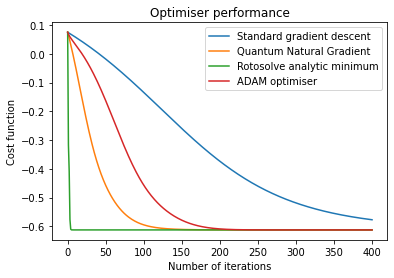

In [5]:
plot_descents(save=True)

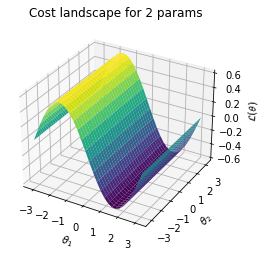

In [45]:
# Cost landscape
X, Y, Z = toymodel['meshgrid']
plot_3d(X, Y, Z, r"$\theta_1$", r"$\theta_2$", r"$\mathcal{L}(\mathbb{\theta})$", "Cost landscape for 2 params", "costlandscapetoy")

In [22]:
with open("./datafiles/output.pkl", "rb") as f:
    maxcutbenchmark = pkl.load(f)

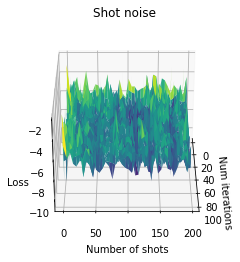

In [92]:
ShotsPlotBenchmark = np.load("./datafiles/shotsmaxcutround2primegd.npy")
Xs = np.arange(100)
Ys = np.arange(1,200,5)
X, Y = np.meshgrid(Xs,Ys)
plot_3d(X, Y, ShotsPlotBenchmark, "Num iterations","Number of shots","Loss","Shot noise", 30, 0.01)

In [95]:
with open("./datafiles/output.pkl", "rb") as f:
    maxout = pkl.load(f)

In [109]:
meshgrids = np.array(maxout['adam']['12, 0.3']['2']['meshgrids'])

In [108]:
X, Y = np.meshgrid(np.arange(50),np.arange(50))

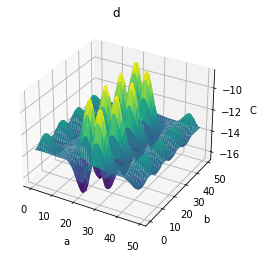

In [110]:
plot_3d(X, Y, meshgrids[0], "a", "b", "C", "d")

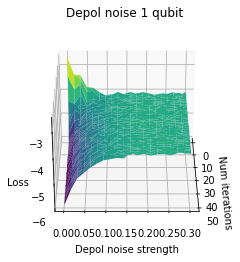

In [60]:
DepolNoise1Qubit = np.load("./datafiles/depolnoise1qubitadam.npy")
Xs = np.arange(50)
Ys = np.linspace(0.001,0.3,20)
X, Y = np.meshgrid(Xs,Ys)
plot_3d(X, Y, DepolNoise1Qubit, "Num iterations","Depol noise strength","Loss","Depol noise 1 qubit", 30, 0.01)


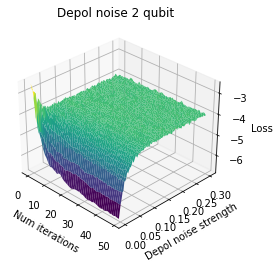

In [39]:
DepolNoise2Qubit = np.load("./datafiles/depolnoise2qubitadam.npy")
Xs = np.arange(50)
Ys = np.linspace(0.001,0.3,100)
X, Y = np.meshgrid(Xs,Ys)
plot_3d(X, Y, DepolNoise2Qubit, "Num iterations","Depol noise strength","Loss","Depol noise 2 qubit", 30, -45)

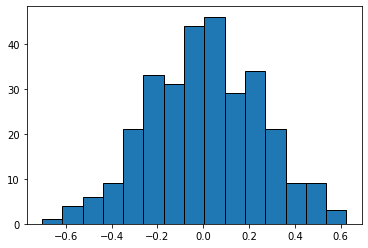

In [70]:
import matplotlib.pyplot as plt
GradDists = np.load("./datafiles/graddists.npy")
frq, edges = np.histogram(GradDists[-1,3,:], 15)

fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")

plt.show()

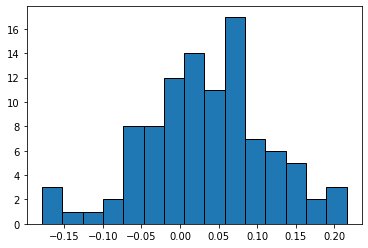

In [88]:
GradDists = np.load("./datafiles/graddistsdepolnoise1qubit.npy")
frq, edges = np.histogram(GradDists[-10,3,:], 15)

fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")

plt.show()

In [59]:
Ys

array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0.06744444, 0.07046465, 0.07348485,
       0.07650505, 0.07952525, 0.08254545, 0.08556566, 0.08858586,
       0.09160606, 0.09462626, 0.09764646, 0.10066667, 0.10368687,
       0.10670707, 0.10972727, 0.11274747, 0.11576768, 0.11878788,
       0.12180808, 0.12482828, 0.12784848, 0.13086869, 0.13388889,
       0.13690909, 0.13992929, 0.14294949, 0.1459697 , 0.1489899 ,
       0.1520101 , 0.1550303 , 0.15805051, 0.16107071, 0.16409091,
       0.16711111, 0.17013131, 0.17315152, 0.17617172, 0.17919192,
       0.18221212, 0.18523232, 0.18825253, 0.19127273, 0.19429293,
       0.19731313, 0.20033333, 0.20335354, 0.20637374, 0.20939394,
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449